In [37]:
import numpy as np
from scipy.interpolate import CubicSpline
from scipy.integrate import quad
import scipy.stats as stats
from multiprocess import Pool
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import QuantLib as ql
import matplotlib.pyplot as plt

In [38]:
# Flat Yield Curve
flat_yields = [
    (0.5, .03),
    (2.0, .03),
    (5.0, .03),
    (10.0, .03),
]

In [39]:
# Extract durations and yields
yield_curve = flat_yields
durations = [item[0] for item in yield_curve]
yields = [item[1] for item in yield_curve]

# Fit cubic spline
yield_curve = CubicSpline(durations, yields)

## Hull-White Testing

In [40]:
# Simulation's Parameters
T = 5                      # Years of Simulation
days_per_year = 52         # Days in the Year
steps = int(T*days_per_year)    # Number of steps
dt = 1.0 * T / steps            # Time step size
simulations = 10000         # Amount of Monte Carlo runs
r0 = 0.3

# Parameters for the Hull-White model
# a: How fast is convergence to the original Yield Structure. Typical Range: [0.01, 0.1], our range: [0.01, 0.1]
# sigma: Variance of rates. Typical range: [0.001, 0.02], our range: [0.002, 0.01]
a = 0.01
sigma = 0.01
theta = lambda t: yield_curve.derivative(nu=1)(t) + (a*yield_curve(t)) + ((sigma**2)/(2*a))*(1-np.exp(-2*a*t))

In [41]:
analytical_short_rates = []
for t in np.linspace(0, T, steps):
    integral = 0
    for u in np.linspace(0, t, int(t*days_per_year)):
        integral += np.exp(a*(u-t))*theta(u)*dt         # du=dt as we keep discretization step size same
    rate_t = r0*np.exp(a*(0-t)) + integral
    analytical_short_rates.append(rate_t)
mean_sol = np.mean(analytical_short_rates)              # Should we add confidence interval?

analytical_variance_rates = []
for t in np.linspace(0, T, steps):
    var_t = ((np.square(sigma))/(2*a)) * (1 - np.exp(2 * a * (0-t)))
    analytical_variance_rates.append(var_t)
variance_sol = np.mean(analytical_variance_rates)       # Should we add confidence interval?

print("Analytical Solution for the Mean: ", mean_sol)
print("Analytical Solution for the Variance: ", variance_sol)

Analytical Solution for the Mean:  0.2937591215178612
Analytical Solution for the Variance:  0.00024185559504342666


In [42]:
def simulate_path(params):

    _, steps, dt, r0, a, sigma, theta, yield_curve = params

    import numpy as np
    np.random.seed(_)       # So that values in each processor is unique

    theta = lambda t: yield_curve.derivative(nu=1)(t) + (a*yield_curve(t)) + ((sigma**2)/(2*a))*(1-np.exp(-2*a*t))
    Z = np.random.normal(0, 1, steps)
    dr = np.zeros(steps)
    r = np.zeros(steps)
    r[0] = r0  # Initialize with the initial rate from the market
    for t in range(1, steps):
        dr[t] = (theta(t * dt) - a * r[t-1]) * dt + sigma * np.sqrt(dt) * Z[t]
        r[t] = r[t-1] + dr[t]
    return r

# Use multiprocess to run simulations in parallel
simulation_params = [(i, steps, dt, r0, a, sigma, theta, yield_curve) for i in range(simulations)]     # Fixed Seed
#simulation_params = [(np.random.randint((i+10)*100), steps, dt, r0, a, sigma, theta, yield_curve) for i in range(simulations)]     # Pseudo Random Seed

# Run in Parallel
with Pool() as pool:
    short_rate_paths = pool.map(simulate_path, simulation_params)

# Convert list of arrays to a 2D NumPy array
short_rate_paths = np.array(short_rate_paths)

In [43]:
# Some variables necessary for statistical tests
confidence_level = 0.95
d_f = simulations - 1
# T-test for the Mean
t_critical = stats.t.ppf((1 + confidence_level) / 2, d_f)
# Chi-squared test for the Variance
chi2_lower = stats.chi2.ppf((1 - confidence_level) / 2, d_f)
chi2_upper = stats.chi2.ppf((1 + confidence_level) / 2, d_f)

# Mean
sim_means = [np.mean(short_rates) for short_rates in short_rate_paths.T]    # We have to transpose, because analytical value is obtained per each time point, not per path
overall_sim_mean = np.mean(sim_means)
# Confidence Interval for the mean
mean_err = stats.sem(sim_means)  # Standard Error Mean
ci_mean = t_critical * mean_err
print("Simulation's Short Rate Mean: ", overall_sim_mean, ", with a ci: [", overall_sim_mean-ci_mean, ", ", overall_sim_mean+ci_mean, "]")

# Variance
sim_vars = [np.var(short_rates, ddof=1) for short_rates in short_rate_paths.T]    # degree_of_freedom = n-1, because it is variance
overall_sim_var = np.mean(sim_vars) + np.var(sim_vars, ddof=1)  # Variance within and between
# Confidence Interval for the variance
ci_variance_lower = (d_f * overall_sim_var) / chi2_upper
ci_variance_upper = (d_f * overall_sim_var) / chi2_lower
print("Simulation's Short Rate Variance is: ", overall_sim_var, ", with a ci: [", ci_variance_lower, ", ", ci_variance_upper, "]")

Simulation's Short Rate Mean:  0.2939605294522428 , with a ci: [ 0.2935568034725696 ,  0.294364255431916 ]
Simulation's Short Rate Variance is:  0.0002443589171227945 , with a ci: [ 0.00023772440393182622 ,  0.0002512764392061134 ]


In [44]:
print(f'MAE Mean: {mean_sol - overall_sim_mean}')
print(f'MAE Variance: {variance_sol - overall_sim_var}')

MAE Mean: -0.00020140793438161442
MAE Variance: -2.5033220793678414e-06


In [45]:
last_points = short_rate_paths[:,-1]

In [46]:
print(np.mean(last_points))
print(stats.sem(last_points))

0.2883248187220878
0.00022030725040825123


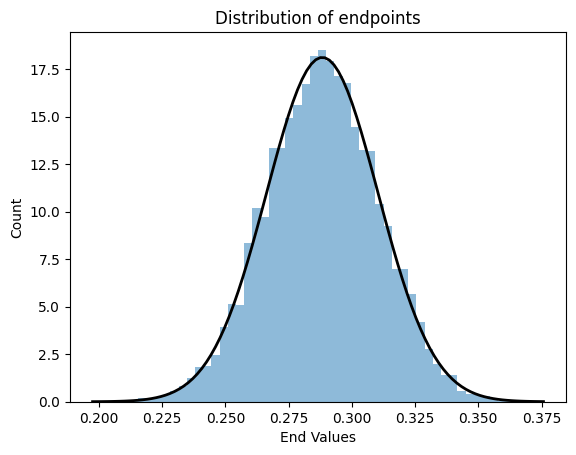

In [47]:
from scipy.stats import norm
plt.hist(last_points, bins=50, density=True, alpha=0.5)
# Fitting a normal distribution to the data
mu, std = norm.fit(last_points)

# Plotting the fitted normal distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
#real = norm.pdf(x, 0.04, 0.01)
plt.plot(x, p, 'k', linewidth=2)
plt.xlabel('End Values')
plt.ylabel('Count')
plt.title('Distribution of endpoints')
#plt.plot(x, real, 'k', linewidth=2)
plt.show()

## Bonds

In [48]:
def P_other(s, t, r_s, a, sigma, yield_curve):

    def A(s, t, a, sigma, yield_curve):
        P_0_t = 1/(1+yield_curve(t))**t     # Value of Zero Coupon Bond (0,t)
        P_0_s = 1/(1+yield_curve(s))**s     # Value of Zero Coupon Bond (0,s)
        term1 = P_0_t/P_0_s
        term2 = B(s, t, a) * yield_curve(s) # B * Instantenious Forward Rate
        term3 = (sigma**2/(4*a)) * B(s,t,a)**2 * (1-np.exp(-2*a*s))
        return term1*np.exp(term2-term3)

    def B(s, t, a):
        return 1/a * (1 - np.exp(a * (s - t)))

    return A(s, t, a, sigma, yield_curve) * np.exp(-B(s, t, a) * r_s)     # Short rate and initial rate are the same here

In [49]:
def P(s, t, r_s, a, sigma, yield_curve):

    def A(s, t, a, sigma, yield_curve):
        P_0_t = np.exp(-yield_curve(t) * t)
        P_0_s = np.exp(-yield_curve(s) * s)
        term1 = P_0_t/P_0_s
        term2 = B(s, t, a) * yield_curve(s) # B * Instantenious Forward Rate
        term3 = (sigma**2/(4*a)) * B(s,t,a)**2 * (1-np.exp(-2*a*s))
        return term1*np.exp(term2-term3)

    def B(s, t, a):
        return 1/a * (1 - np.exp(a * (s - t)))

    return A(s, t, a, sigma, yield_curve) * np.exp(-B(s, t, a) * r_s)     # Short rate and initial rate are the same here

In [50]:
def bond_price_ql(s, t, r):
    # Verifying found Price
    todays_date = ql.Date.todaysDate()
    ql.Settings.instance().evaluationDate = todays_date + ql.Period(int(s*12), ql.Months)

    # Create a bond object
    issue_date = todays_date + ql.Period(int(s*12), ql.Months)
    maturity_date = todays_date + ql.Period(int(t*12), ql.Months)
    bond = ql.ZeroCouponBond(0, ql.NullCalendar(), 1.0, maturity_date)

    # Set up the bond engine
    spot_curve_handle = ql.YieldTermStructureHandle(ql.FlatForward(issue_date, r, ql.Actual365Fixed()))
    bond_engine = ql.DiscountingBondEngine(spot_curve_handle)

    # Calculate the bond price
    bond.setPricingEngine(bond_engine)
    bond_NPV = bond.NPV()

    return bond_NPV

In [51]:
s = 1
t = 12
r = 0.04
sigma = 0.0037
print(f'MAE = {P(s, t, r, a, sigma, yield_curve) - bond_price_ql(s, t, r)}')
print(f'MAE_not_continious = {P_other(s, t, r, a, sigma, yield_curve) - bond_price_ql(s, t, r)}')

MAE = 0.0034333386173837077
MAE_not_continious = 0.006582573611384035


## Swaps

In [52]:
t = 0
T_0 = 1
T_m = 5
notional = N = 1
tenor = 1
K = 0.03
theta = lambda t: yield_curve.derivative(nu=1)(t) + (a*yield_curve(t)) + ((sigma**2)/(2*a))*(1-np.exp(-2*a*t))
days_per_year = 360

In [53]:
t = 0                # Point in time when we are looking for contract
tenor = 1         # Semi-Annual settlement possibility, delta t_i
T_0 = t + tenor         # Point in time when contract starts, in our case only structure where first payment is possible after a tenor is supported. (no custom no-call periods)
T_m = 6         # Point in time when contract ends (Maturity)
fixed_rate = 0.03       # Same as Strike Rate in simple options
r0 = 0.03                # Initial Forward Interest Rate
rates_example = np.ones(int(20.0*days_per_year))*r                 # Assume flat rates
yield_curve_examples = CubicSpline(np.arange(int(20.0*days_per_year)), rates_example)
sigma = 0.01
a = 0.01

In [54]:
def swap(t, T_0, T_m, notional, tenor, K, yield_curve, r, sigma, a):
    summation = K * sum([P(t, i, r, a, sigma, yield_curve) for i in range(T_0 + tenor, T_m + tenor, tenor)])
    floating = P(t, T_0, r, a, sigma, yield_curve) - P(t, T_m, r, a, sigma, yield_curve)
    return -1 * notional * (floating - summation)

In [55]:
# Verifying values by running a simulation with the QuantLib (only works with flat curve)
def swap_value_ql(t, T_0, T_m, fixed_rate, tenor, r0, notional):

    # Setup the market and yield term structure
    calendar = ql.TARGET()
    day_count = ql.Actual365Fixed()
    todays_date = ql.Date.todaysDate()
    # Update the evaluation date
    evaluation_date = todays_date + ql.Period(int(t*12), ql.Months)
    ql.Settings.instance().evaluationDate = evaluation_date
    flat_forward = ql.FlatForward(evaluation_date, r0, day_count)     # Flat rate curve
    yield_curve_handle = ql.YieldTermStructureHandle(flat_forward)

    # Swaption characteristics
    # Define the fixed-rate leg
    maturity_date = todays_date + ql.Period(int(T_m*12), ql.Months)
    fixed_leg_tenor = ql.Period(int(tenor*12), ql.Months)
    fixed_leg_schedule = ql.Schedule(todays_date+ql.Period(int(T_0*12), ql.Months), maturity_date, fixed_leg_tenor, calendar,
                                    ql.ModifiedFollowing, ql.ModifiedFollowing,
                                    ql.DateGeneration.Forward, False)

    # Define the floating-rate leg
    index = ql.IborIndex("CustomEuriborM", ql.Period(int(tenor*12), ql.Months), 0, ql.EURCurrency(), calendar, ql.ModifiedFollowing, False, day_count, yield_curve_handle)
    floating_leg_schedule = ql.Schedule(todays_date+ql.Period(int(T_0*12), ql.Months), maturity_date, index.tenor(), calendar,
                                        ql.ModifiedFollowing, ql.ModifiedFollowing,
                                        ql.DateGeneration.Forward, False)

    # Create the swap
    vanilla_swap = ql.VanillaSwap(ql.VanillaSwap.Receiver, N, fixed_leg_schedule,
                                fixed_rate, day_count, floating_leg_schedule,
                                index, 0.0, index.dayCounter())
    vanilla_swap.setPricingEngine(ql.DiscountingSwapEngine(yield_curve_handle))

    # Calculate the NPV
    swap_NPV = vanilla_swap.NPV()
    return notional * swap_NPV

print("QuantLib Swap price is: ", swap_value_ql(t, T_0, T_m, K, tenor, r0, notional))

QuantLib Swap price is:  -0.002014746597965189


In [56]:
print(swap(t, T_0, T_m, notional, tenor, K, yield_curve, r0, sigma, a))

-0.0020174918349673276


In [57]:
print(f'MAE = {swap(t, T_0, T_m, notional, tenor, K, yield_curve, r0, sigma, a) - swap_value_ql(t, T_0, T_m, K, tenor, r0, notional)}')

MAE = -2.7452370021385786e-06


In [58]:
relative_error = (swap(t, T_0, T_m, notional, tenor, K, yield_curve, r0, sigma, a) - swap_value_ql(t, T_0, T_m, K, tenor, r0, notional)) / swap_value_ql(t, T_0, T_m, K, tenor, r0, notional)

In [59]:
print(relative_error * 100)

0.13625718514234766


## Swaption

- LS
- Benchmark
- MC Simulation

In [60]:
def swap_rate(T_0, T_m, tenor, s, t, r_s, a, sigma, yield_curve):
    summation = sum([P(T_0, i, r, a, sigma, yield_curve) * tenor for i in range(T_0 + tenor, T_m + tenor, tenor)])
    top = 1 - P(T_0, T_m, r, a, sigma, yield_curve)
    return top / summation

In [61]:
def swaption(T_0, T_m, notional, tenor, K, yield_curve, r0, sigma, a):
    s_0 = swap_rate(T_0, T_m, tenor, s, t, r0, a, sigma, yield_curve)
    annuity = sum([P(T_0, i, r, a, sigma, yield_curve) * tenor for i in range(T_0 + tenor, T_m + tenor, tenor)])
    return notional * annuity * (s_0 - K)

In [62]:
# s_0 = swap_rate(T_0, T_m, tenor, s, t, r0, a, sigma, yield_curve)

In [63]:
PV_swaption = -1 * swaption(T_0, T_m, notional, tenor, K, yield_curve, r, sigma, a) * np.exp((t - T_0) * r0)

In [64]:
# Verifying values by running a simulation with the QuantLib (only works with flat curve)
def swap_value_ql(t, T_0, T_m, fixed_rate, tenor, r0, notional):

    # Setup the market and yield term structure
    calendar = ql.TARGET()
    day_count = ql.Actual365Fixed()
    todays_date = ql.Date.todaysDate()
    # Update the evaluation date
    evaluation_date = todays_date + ql.Period(int(t*12), ql.Months)
    ql.Settings.instance().evaluationDate = evaluation_date
    flat_forward = ql.FlatForward(evaluation_date, r0, day_count)     # Flat rate curve
    yield_curve_handle = ql.YieldTermStructureHandle(flat_forward)

    # Swaption characteristics
    # Define the fixed-rate leg
    maturity_date = todays_date + ql.Period(int(T_m*12), ql.Months)
    fixed_leg_tenor = ql.Period(int(tenor*12), ql.Months)
    fixed_leg_schedule = ql.Schedule(todays_date+ql.Period(int(T_0*12), ql.Months), maturity_date, fixed_leg_tenor, calendar,
                                    ql.ModifiedFollowing, ql.ModifiedFollowing,
                                    ql.DateGeneration.Forward, False)

    # Define the floating-rate leg
    index = ql.IborIndex("CustomEuriborM", ql.Period(int(tenor*12), ql.Months), 0, ql.EURCurrency(), calendar, ql.ModifiedFollowing, False, day_count, yield_curve_handle)
    floating_leg_schedule = ql.Schedule(todays_date+ql.Period(int(T_0*12), ql.Months), maturity_date, index.tenor(), calendar,
                                        ql.ModifiedFollowing, ql.ModifiedFollowing,
                                        ql.DateGeneration.Forward, False)

    # Create the swap
    vanilla_swap = ql.VanillaSwap(ql.VanillaSwap.Receiver, notional, fixed_leg_schedule,
                                fixed_rate, day_count, floating_leg_schedule,
                                index, 0.0, index.dayCounter())
    vanilla_swap.setPricingEngine(ql.DiscountingSwapEngine(yield_curve_handle))

    # Calculate the NPV
    swap_NPV = vanilla_swap.NPV()
    return swap_NPV

print("QuantLib Swap price is: ", swap_value_ql(t, T_0, T_m, fixed_rate, tenor, r, notional))

QuantLib Swap price is:  -0.046095779395846664


In [65]:
print(PV_swaption)

-0.046555364039593664


In [66]:
print(f'MAE = {np.abs(PV_swaption - swap_value_ql(t, T_0, T_m, fixed_rate, tenor, r, notional))}')

MAE = 0.00045958464374699914


In [67]:
relative_error = (PV_swaption - swap_value_ql(t, T_0, T_m, fixed_rate, tenor, r, notional)) / swap_value_ql(t, T_0, T_m, fixed_rate, tenor, r, notional)

In [68]:
print(f'RE: {relative_error * 100}')

RE: 0.9970210934071086


### Bermudan Price